In [1]:
# Employee Sentiment Analysis Project (BERT-based)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os

# Plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
tqdm.pandas()


c:\Users\harsh\miniconda3\envs\mist7bi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
df = pd.read_csv('test.csv')
df.columns = ['subject', 'body', 'date', 'sender_email']
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['subject'] = df['subject'].fillna('')
df['body'] = df['body'].fillna('')
df['text'] = df['subject'] + " " + df['body']

# Extract employee_id from email (before @)
df['employee_id'] = df['sender_email'].str.extract(r'([^@]+)@')[0]


In [5]:
# Load sentiment pipeline
sentiment_pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Label mapping
def map_label(pred):
    label = pred['label']
    if label == "LABEL_0":
        return "Negative"
    elif label == "LABEL_1":
        return "Neutral"
    elif label == "LABEL_2":
        return "Positive"
    else:
        return "Unknown"

# Predict sentiments
df['sentiment'] = df['text'].progress_apply(lambda x: map_label(sentiment_pipe(x)[0]))
print(df['sentiment'].value_counts())
df.to_csv("labeled_sentiments_roberta.csv", index=False)


c:\Users\harsh\miniconda3\envs\mist7bi\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 2191/2191 [02:10<00:00, 16.76it/s]

sentiment
Neutral     1505
Positive     538
Negative     148
Name: count, dtype: int64


sentiment
Neutral     1505
Positive     538
Negative     148
Name: count, dtype: int64
Total messages: 2191
Unique employees: 10
Date range: 2010-01-01 00:00:00 to 2011-12-31 00:00:00


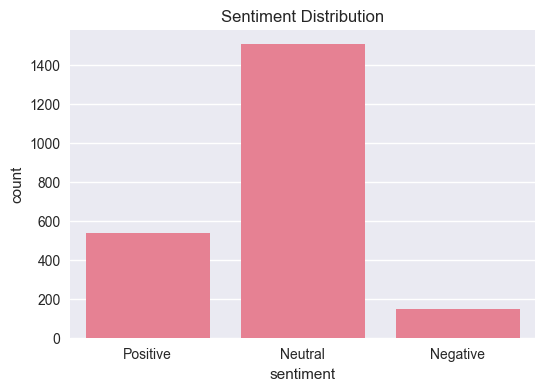

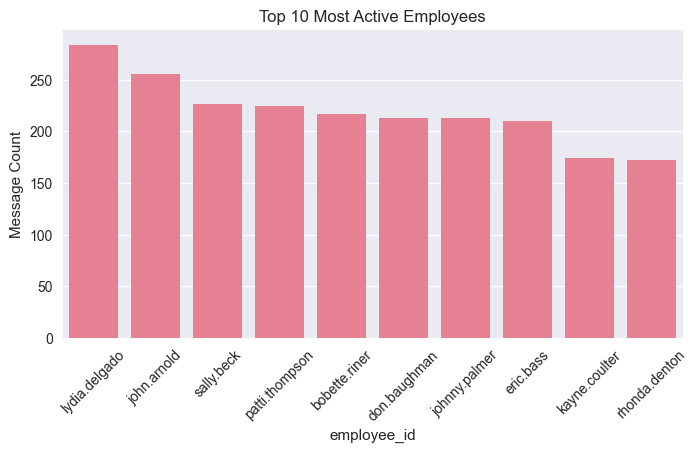

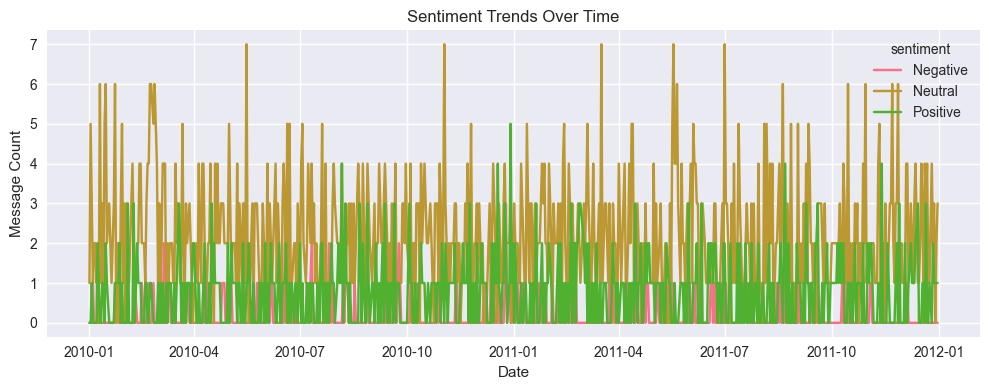

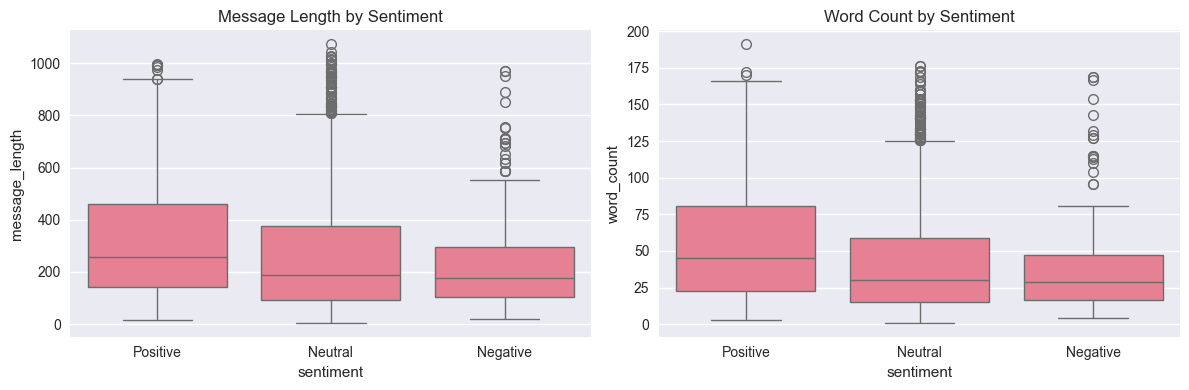

In [7]:
# Create visualizations directory
os.makedirs('visualizations', exist_ok=True)
# After sentiment labeling
print(df['sentiment'].value_counts())

print(f"Total messages: {len(df)}")
print(f"Unique employees: {df['employee_id'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Sentiment distribution plot
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, order=['Positive','Neutral','Negative'])
plt.title('Sentiment Distribution')
plt.savefig('visualizations/sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Messages per employee
plt.figure(figsize=(8, 4))
top_employees = df['employee_id'].value_counts().head(10)
sns.barplot(x=top_employees.index, y=top_employees.values)
plt.xticks(rotation=45)
plt.title('Top 10 Most Active Employees')
plt.ylabel('Message Count')
plt.savefig('visualizations/messages_per_employee.png', dpi=300, bbox_inches='tight')
plt.show()

# Sentiment over time
if not df['date'].isnull().all():
    plt.figure(figsize=(10, 4))
    daily = df.groupby([df['date'].dt.date, 'sentiment']).size().unstack(fill_value=0)
    daily.plot(ax=plt.gca())
    plt.title('Sentiment Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Message Count')
    plt.tight_layout()
    plt.savefig('visualizations/sentiment_trends_time.png', dpi=300, bbox_inches='tight')
    plt.show()

# Message length by sentiment
df['message_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x='sentiment', y='message_length', data=df, order=['Positive','Neutral','Negative'])
plt.title('Message Length by Sentiment')
plt.subplot(1, 2, 2)
sns.boxplot(x='sentiment', y='word_count', data=df, order=['Positive','Neutral','Negative'])
plt.title('Word Count by Sentiment')
plt.tight_layout()
plt.savefig('visualizations/message_stats_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# Assign score to each sentiment
score_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['message_score'] = df['sentiment'].map(score_map)

# Group by employee and month
df['year_month'] = df['date'].dt.to_period('M')
monthly_scores = df.groupby(['employee_id', 'year_month']).agg(
    message_score=('message_score', 'sum'),
    message_count=('message_score', 'count')
).reset_index()
monthly_scores.head()


,employee_id,year_month,message_score,message_count
0,bobette.riner,2010-01,0,2
1,bobette.riner,2010-02,3,14
2,bobette.riner,2010-03,0,11
3,bobette.riner,2010-04,1,6
4,bobette.riner,2010-05,2,4


In [14]:
rankings = {}
for month in monthly_scores['year_month'].unique():
    month_data = monthly_scores[monthly_scores['year_month'] == month].copy()
    # Top 3 positive
    top_pos = month_data.sort_values(['message_score','employee_id'], ascending=[False, True]).head(3)
    # Top 3 negative
    top_neg = month_data.sort_values(['message_score','employee_id'], ascending=[True, True]).head(3)
    rankings[str(month)] = {
        'top_positive': top_pos,
        'top_negative': top_neg
    }
    print(f"\nMonth: {month}")
    print("Top 3 Positive Employees:")
    print(top_pos[['employee_id','message_score','message_count']])
    print("Top 3 Negative Employees:")
    print(top_neg[['employee_id','message_score','message_count']])



Month: 2010-01
Top 3 Positive Employees:
       employee_id  message_score  message_count
48       eric.bass              3             10
24    don.baughman              2              9
120  kayne.coulter              2             22
Top 3 Negative Employees:
       employee_id  message_score  message_count
0    bobette.riner              0              2
192  rhonda.denton              0              3
216     sally.beck              0              9

Month: 2010-02
Top 3 Positive Employees:
      employee_id  message_score  message_count
1   bobette.riner              3             14
25   don.baughman              3             15
97  johnny.palmer              3             18
Top 3 Negative Employees:
       employee_id  message_score  message_count
121  kayne.coulter             -1              8
217     sally.beck             -1              6
73     john.arnold              0             18

Month: 2010-03
Top 3 Positive Employees:
     employee_id  message_score  message_c

In [15]:
# Any employee with 4+ negative mails in any rolling 30-day period
flight_risk_employees = set()
negatives = df[df['sentiment'] == 'Negative'].copy().sort_values('date')
for emp in negatives['employee_id'].unique():
    emp_neg = negatives[negatives['employee_id'] == emp].sort_values('date')
    dates = emp_neg['date'].tolist()
    for i in range(len(dates)):
        window = [d for d in dates if d >= dates[i] and d <= dates[i] + timedelta(days=30)]
        if len(window) >= 4:
            flight_risk_employees.add(emp)
            break
print(f"\nFlight risk employees: {flight_risk_employees}")



Flight risk employees: {'rhonda.denton', 'eric.bass', 'john.arnold', 'don.baughman'}



Regression R²: 0.6068, MSE: 1.6542


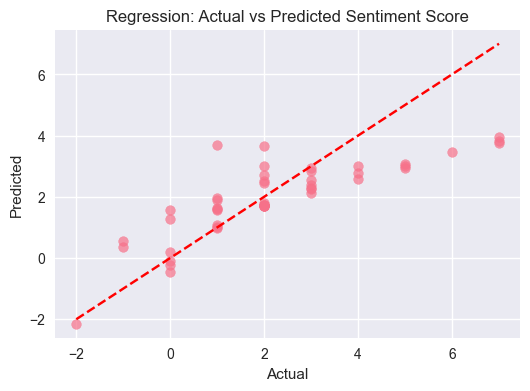

In [16]:
# Features for regression: message_count, avg_message_length, avg_word_count, positive_ratio, negative_ratio
feature_data = []
for _, row in monthly_scores.iterrows():
    emp = row['employee_id']
    month = row['year_month']
    group = df[(df['employee_id'] == emp) & (df['year_month'] == month)]
    feature_data.append({
        'employee_id': emp,
        'year_month': month,
        'message_count': len(group),
        'avg_message_length': group['message_length'].mean(),
        'avg_word_count': group['word_count'].mean(),
        'positive_ratio': (group['sentiment'] == 'Positive').mean(),
        'negative_ratio': (group['sentiment'] == 'Negative').mean(),
        'sentiment_score': row['message_score']
    })
features_df = pd.DataFrame(feature_data)
X = features_df[['message_count','avg_message_length','avg_word_count','positive_ratio','negative_ratio']]
y = features_df['sentiment_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nRegression R²: {r2:.4f}, MSE: {mse:.4f}")
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Regression: Actual vs Predicted Sentiment Score')
plt.savefig('visualizations/regression_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
# Save labeled data, scores, and features
df.to_csv('sentiment_labeled_data.csv', index=False)
monthly_scores.to_csv('monthly_employee_scores.csv', index=False)
features_df.to_csv('regression_features.csv', index=False)


In [18]:
print("\n==== SUMMARY FOR README ====")
print(f"Total messages analyzed: {len(df)}")
print(f"Unique employees: {df['employee_id'].nunique()}")
print(f"Flight risk employees: {list(flight_risk_employees)}")

overall_scores = monthly_scores.groupby('employee_id')['message_score'].sum().sort_values(ascending=False)
print(f"Top 3 positive employees (overall): {list(overall_scores.head(3).index)}")
print(f"Top 3 negative employees (overall): {list(overall_scores.tail(3).index)}")
print("Key insights and recommendations: (Fill in after EDA/model review)")



==== SUMMARY FOR README ====
Total messages analyzed: 2191
Unique employees: 10
Flight risk employees: ['rhonda.denton', 'eric.bass', 'john.arnold', 'don.baughman']
Top 3 positive employees (overall): ['johnny.palmer', 'lydia.delgado', 'sally.beck']
Top 3 negative employees (overall): ['don.baughman', 'patti.thompson', 'rhonda.denton']
Key insights and recommendations: (Fill in after EDA/model review)
